In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index]

        if not isinstance(img_path, str):
            print(f"Invalid image path type: {type(img_path)}")
            print(f"Image path value: {img_path}")

        try:
            img = Image.open(img_path).convert("RGB")
        except AttributeError:
            print(f"Invalid image path: {img_path}")
            raise

        if self.transform is not None:
            img = self.transform(img)

        return img, label

D:\Anaconda\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((100,100)),
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((100,100)),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "data/train"

full_dataset = ImageFolder(data_dir, transform=data_transforms["train"])

train_indices, val_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2, random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

val_dataset.dataset.transform = data_transforms["val"]

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [4]:
image,label=next(iter(train_loader))
image.shape

torch.Size([512, 3, 100, 100])

In [5]:
model = models.resnet18(pretrained=True)

num_classes = len(full_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
from tqdm import tqdm
num_epochs = 25
best_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
            dataloader = train_loader
            dataset_size = len(train_dataset)
        else:
            model.eval()
            dataloader = val_loader
            dataset_size = len(val_dataset)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        if phase == "train":
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
        if phase == "val" and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), "Plant_model.pth")
    print()

print(f"Best val Acc: {best_acc:.4f}")


Epoch 0/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


train Loss: 1.8212 Acc: 0.1776


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


val Loss: 1.5716 Acc: 0.3127

Epoch 1/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


train Loss: 1.5486 Acc: 0.3051


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


val Loss: 1.3471 Acc: 0.4982

Epoch 2/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


train Loss: 1.3027 Acc: 0.4959


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


val Loss: 1.0718 Acc: 0.6091

Epoch 3/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


train Loss: 1.0402 Acc: 0.6471


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


val Loss: 0.8910 Acc: 0.7255

Epoch 4/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.60s/it]


train Loss: 0.8722 Acc: 0.7309


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.23it/s]


val Loss: 0.7759 Acc: 0.7418

Epoch 5/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


train Loss: 0.7485 Acc: 0.7719


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]


val Loss: 0.6939 Acc: 0.7673

Epoch 6/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


train Loss: 0.6552 Acc: 0.8015


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


val Loss: 0.6321 Acc: 0.7855

Epoch 7/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.58s/it]


train Loss: 0.5831 Acc: 0.8292


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.20it/s]


val Loss: 0.5858 Acc: 0.7982

Epoch 8/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.57s/it]


train Loss: 0.5231 Acc: 0.8506


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.5540 Acc: 0.8127

Epoch 9/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


train Loss: 0.4774 Acc: 0.8629


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


val Loss: 0.5304 Acc: 0.8218

Epoch 10/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


train Loss: 0.4388 Acc: 0.8739


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.24it/s]


val Loss: 0.5140 Acc: 0.8236

Epoch 11/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.59s/it]


train Loss: 0.4018 Acc: 0.8884


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.4976 Acc: 0.8273

Epoch 12/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.3708 Acc: 0.9012


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.4823 Acc: 0.8291

Epoch 13/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


train Loss: 0.3431 Acc: 0.9076


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.4704 Acc: 0.8309

Epoch 14/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


train Loss: 0.3216 Acc: 0.9203


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.4586 Acc: 0.8382

Epoch 15/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.2975 Acc: 0.9312


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.27it/s]


val Loss: 0.4489 Acc: 0.8418

Epoch 16/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


train Loss: 0.2770 Acc: 0.9408


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


val Loss: 0.4444 Acc: 0.8400

Epoch 17/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.2583 Acc: 0.9463


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


val Loss: 0.4364 Acc: 0.8418

Epoch 18/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


train Loss: 0.2407 Acc: 0.9508


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


val Loss: 0.4292 Acc: 0.8418

Epoch 19/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.55s/it]


train Loss: 0.2247 Acc: 0.9563


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


val Loss: 0.4235 Acc: 0.8418

Epoch 20/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.2122 Acc: 0.9549


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.30it/s]


val Loss: 0.4198 Acc: 0.8436

Epoch 21/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.1979 Acc: 0.9631


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


val Loss: 0.4157 Acc: 0.8436

Epoch 22/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.1862 Acc: 0.9686


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.29it/s]


val Loss: 0.4112 Acc: 0.8491

Epoch 23/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.1737 Acc: 0.9736


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.31it/s]


val Loss: 0.4096 Acc: 0.8491

Epoch 24/24


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.56s/it]


train Loss: 0.1642 Acc: 0.9763


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]

val Loss: 0.4062 Acc: 0.8509

Best val Acc: 0.8509


Text(0.5, 1.0, 'Loss Curve')

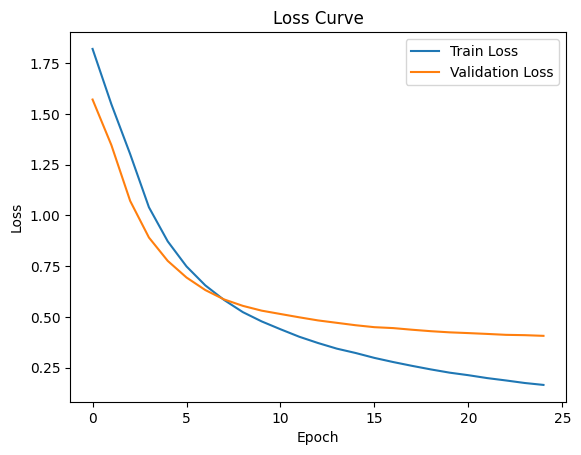

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Train Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
# plt.savefig("loss_curve.png")

In [8]:
train_accuracies = torch.tensor(train_accuracies, device = 'cpu')
val_accuracies=torch.tensor(val_accuracies, device = 'cpu')

Text(0.5, 1.0, 'ACC Curve')

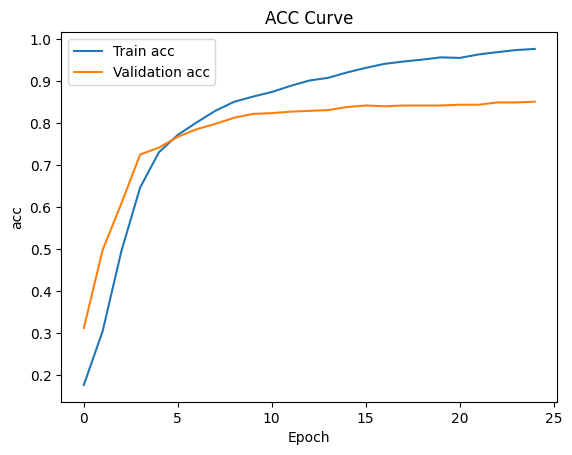

In [9]:
plt.figure()
plt.plot(range(num_epochs), train_accuracies.numpy(), label="Train acc")
plt.plot(range(num_epochs), val_accuracies.numpy(), label="Validation acc")
plt.xlabel("Epoch")
plt.ylabel("acc")
plt.legend()
plt.title("ACC Curve")
# plt.savefig("ACC_curve.png")

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
from torchvision.datasets import ImageFolder

def load_model(model_path, num_classes):
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, class_names, device):
    transform = transforms.Compose([
        transforms.Resize((100,100)),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        confidence, preds = torch.max(outputs.softmax(dim=1), 1)

    return class_names[preds], confidence.item()

model_path = "Plant_model.pth"
image_path = r"D:\PYproject\花朵检索\data\train\rose\3253243865_435c1f2c2b_m.jpg"
data_dir = r"data\train"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_classes = len(os.listdir(data_dir))
# print(num_classes)
class_names = ImageFolder(data_dir).classes
 
model = load_model(model_path, num_classes).to(device)
prediction, confidence = predict(model, image_path, class_names, device)

print(f"Predicted class: {prediction}, Confidence: {confidence:.4f}")


D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted class: rose, Confidence: 0.9510
